In [18]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

# Clinical data preparation (Pre-Training)

In [ ]:
#read the data
pre_training_data_path = "L:/Basic/divi/jstoker/slicer_pdac/Master Students WS 24/Martijn/data/Pre-training/Colorectal-Liver-Metastases-Clinical-data-April-2023.xlsx"
pre_training_data = pd.read_excel(pre_training_data_path)


In [ ]:
relevant_data = pre_training_data[['Patient-ID', 'overall_survival_months']]
relevant_data = relevant_data.drop(index=72) #this patient was scanned on its stomach

relevant_data.isna().sum()


Patient-ID                 0
overall_survival_months    0
dtype: int64

In [5]:
# Initialize the Kaplan-Meier fitter
kmf = KaplanMeierFitter()

# Fit the data
kmf.fit(durations=relevant_data['overall_survival_months'], event_observed=None)

# Plot the Kaplan-Meier survival curve
plt.figure(figsize=(10, 6))
kmf.plot_survival_function()
plt.title('Kaplan-Meier Curve for Overall Survival')
plt.xlabel('Time (months)')
plt.ylabel('Survival Probability')
plt.grid(True)
plt.show()

In [ ]:
# Read the metadata CSV file
metadata_path = "L:/Basic/divi/jstoker/slicer_pdac/Master Students WS 24/Martijn/data/Pre-training/dataset/metadata.csv"

# Replace with the actual path to your metadata file
metadata = pd.read_csv(metadata_path)

print(metadata['Number of Images'])

#max number of images is 126

# Clinical data preparation (Training, CAIRO5)

In [ ]:
#Read in the data
data_path = "L:/Basic/divi/jstoker/slicer_pdac/Master Students WS 24/Martijn/data/dataset_CAESAR_dec23_MASTER.xlsx"
all_data = pd.read_excel(data_path)

In [ ]:
relavant_data = all_data[["SubjectKey", "KRAS", "BRAF", "NRAS", "treatment", "PFSm", "OSm"]] 
relavant_data.head()

,SubjectKey,KRAS,BRAF,NRAS,treatment,PFSm,OSm
0,1,0,1,0,FOLFOX-B,11.400411,22.406571
1,2,0,0,0,FOLFOX-P,7.687885,48.394251
2,3,1,0,0,FOLFOX-B,8.147844,31.671458
3,4,0,0,0,FOLFOX-P,21.880903,37.355236
4,5,0,0,0,FOLFIRI-B,1.609856,4.435318


In [ ]:
# SELECT SUBJECTS WITH SCANS

scans_path = "L:/Basic/divi/jstoker/slicer_pdac/Master Students WS 24/Martijn/data/Training/paired_scans"
subjects = []

for scan in os.listdir(scans_path):
    subject = scan.split("_")[0]
    subject_int = int(subject[-3:])
    subjects.append(subject_int)

training_data = relavant_data[relavant_data["SubjectKey"].isin(subjects)]

In [ ]:
# 2 missing subjects: 73, 406       
missing_subjects = set(subjects) - set(training_data["SubjectKey"])
print(missing_subjects)


set()


Delete scans of patient 104,
Check what happend with patients 73 and 406

## Create input and labels

In [ ]:
# ------------------------------------
# CREATE INPUT CSV
# ------------------------------------

training_input = training_data[["SubjectKey", "KRAS", "BRAF", "NRAS", "treatment"]].copy()

# One-hot encode treatment into two categories: ending with 'P' or 'B'
training_input['treatment_P'] = training_input['treatment'].str.endswith('P').astype(int)
training_input['treatment_B'] = training_input['treatment'].str.endswith('B').astype(int)

training_input.drop(columns=["SubjectKey", "treatment", "TRG_cat"], inplace= True)

#-----------------------------
# LABELS
#-------------------------------

#one-hot encode path. response into three categories: no resp, partial response, major response
#Nan is all 0
# One-hot encode the TRG_cat column into three categories
training_labels['no_resp'] = (training_labels['TRG_cat'] == 'No histological response').astype(int)
training_labels['partial_resp'] = (training_labels['TRG_cat'] == 'Partial histological response').astype(int)
training_labels['major_resp'] = (training_labels['TRG_cat'] == 'Major histological response').astype(int)

# Fill NaN values with 0
training_labels[['no_resp', 'partial_resp', 'major_resp']] = training_labels[['no_resp', 'partial_resp', 'major_resp']].fillna(0)

# Save the training input to a CSV file
training_input.to_csv('training_input.csv', index=False)

# ------------------------------------
# CREATE LABEL CSV
# ------------------------------------

training_labels = training_data[["SubjectKey", "PFSm", "OSm"]].copy()

# Create thresholds
half_year_pfs, one_year_pfs, two_year_pfs = 6, 12, 24  
one_year_os, three_year_os, five_year_os = 12, 36, 60 

# Create one-hot encoded columns for progression-free survival thresholds
training_labels['6m_PFS'] = (training_labels['PFSm'] >= half_year_pfs).astype(int)
training_labels['1y_PFS'] = (training_labels['PFSm'] >= one_year_pfs).astype(int)
training_labels['2y_PFS'] = (training_labels['PFSm'] >= two_year_pfs).astype(int)

# Create one-hot encoded columns for overall survival thresholds
training_labels['1y_OS'] = (training_labels['OSm'] >= one_year_os).astype(int)
training_labels['3y_OS'] = (training_labels['OSm'] >= three_year_os).astype(int)
training_labels['5y_OS'] = (training_labels['OSm'] >= five_year_os).astype(int)

training_labels.drop(columns=["SubjectKey", "PFSm", "OSm", "TRG_cat"], inplace= True)

# Save the training labels to a CSV file
training_labels.to_csv('training_labels.csv', index=False)

In [ ]:
training_labels.head()

,TRG_no_resp,TRG_partial_resp,TRG_major_resp,6m_PFS,1y_PFS,2y_PFS,1y_OS,3y_OS,5y_OS
0,0,0,0,1,0,0,1,0,0
1,0,0,0,1,1,0,1,1,0
2,0,0,1,1,1,1,1,1,1
3,1,0,0,1,0,0,1,1,0
4,0,0,0,1,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...
283,0,0,0,1,1,0,1,0,0
284,0,0,0,1,0,0,1,0,0
285,0,1,0,1,0,0,1,0,0
286,1,0,0,1,0,0,1,0,0


## Plots & Exploration

### Mutation status

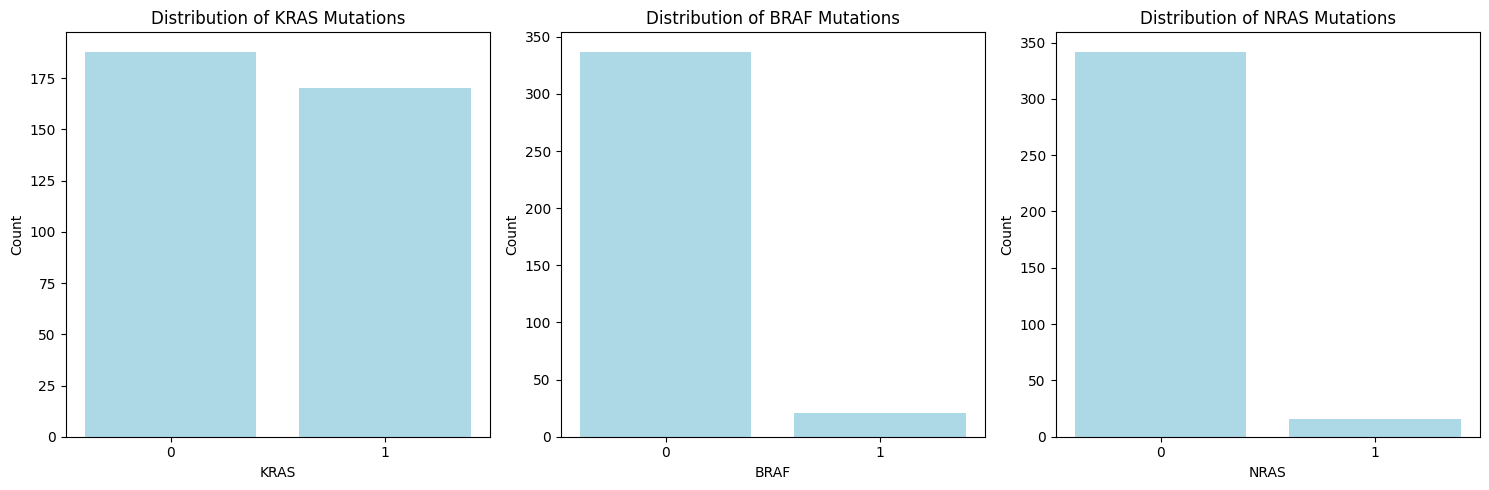

In [ ]:
# Define the list of mutation columns to plot
mutation_columns = ["KRAS", "BRAF", "NRAS"]

# Create a figure with subplots
fig, axes = plt.subplots(nrows=1, ncols=len(mutation_columns), figsize=(15, 5))

# Create bar plots for each mutation type
for ax, mutation in zip(axes, mutation_columns):
    mutation_counts = training_data[mutation].value_counts()

    # Create a bar plot
    ax.bar(mutation_counts.index, mutation_counts.values, color='lightblue')

    # Add labels and title
    ax.set_xlabel(mutation)
    ax.set_ylabel('Count')
    ax.set_title(f'Distribution of {mutation} Mutations')

    # Fix the x-axis to display only 0 and 1
    ax.set_xticks([0, 1])

# Adjust layout
plt.tight_layout()

# Display the combined figure
plt.show()


### Treatment

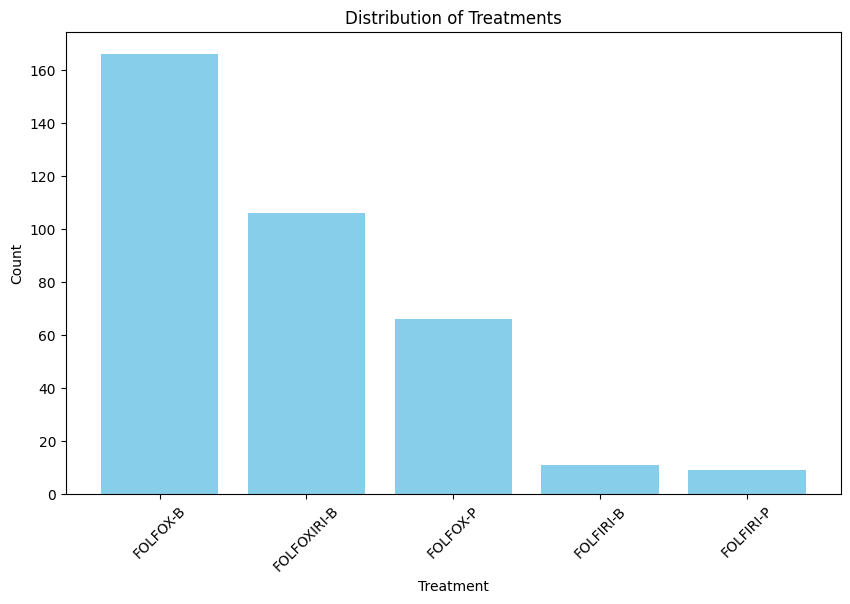

In [ ]:
# Count the occurrences of each treatment type
treatment_counts = training_data["treatment"].value_counts()

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(treatment_counts.index, treatment_counts.values, color='skyblue')

# Add labels and title
plt.xlabel('Treatment')
plt.ylabel('Count')
plt.title('Distribution of Treatments')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Display the plot
plt.show()


### Overall survival

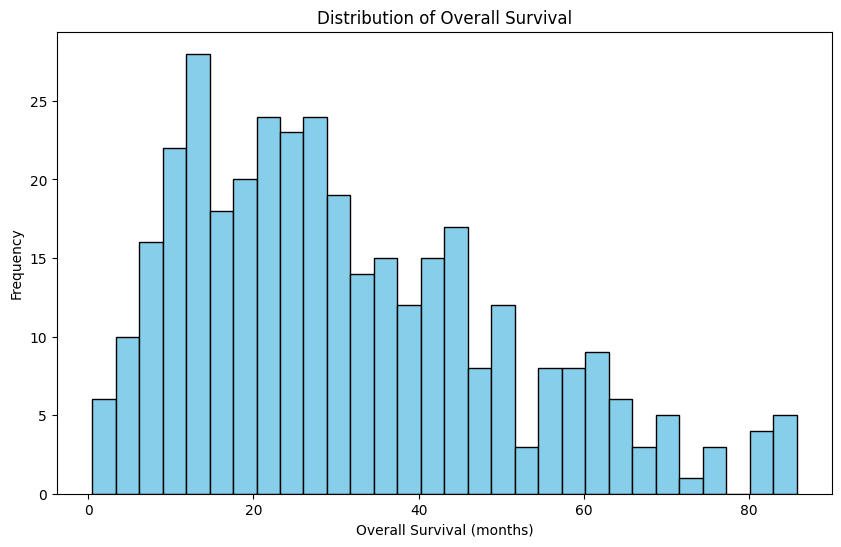

In [ ]:
# Initialize the Kaplan-Meier fitter
kmf = KaplanMeierFitter()

# Fit the data
kmf.fit(durations=training_data['OSm'], event_observed=None)

# Plot the Kaplan-Meier survival curve
plt.figure(figsize=(10, 6))
kmf.plot_survival_function()
plt.title('Kaplan-Meier Curve for Overall Survival')
plt.xlabel('Time (months)')
plt.ylabel('Survival Probability')
plt.grid(True)
plt.show()

### Progression Free Survival

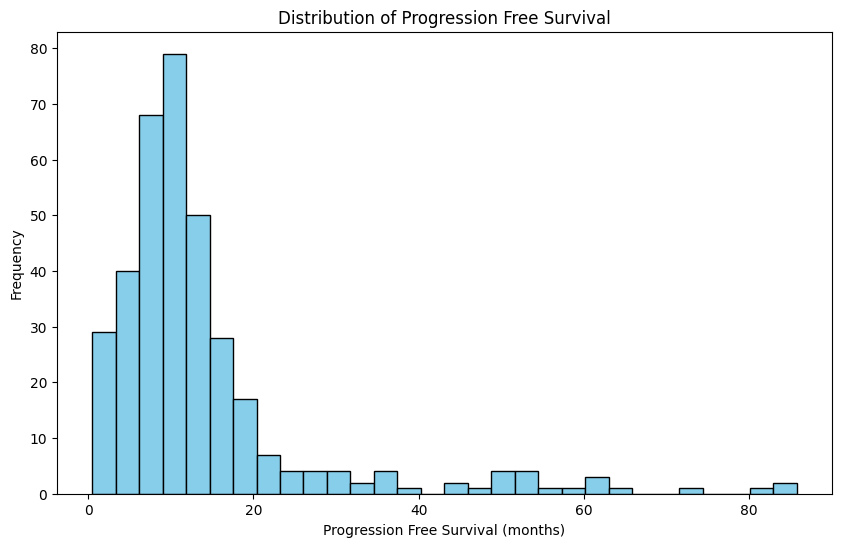

In [ ]:
# Create a histogram plot for the distribution of progression free survival (PFSm)
# make this kaplan meier curve

plt.figure(figsize=(10, 6))
plt.hist(training_data['PFSm'], bins=30, color='skyblue', edgecolor='black')

# Add labels and title
plt.xlabel('Progression Free Survival (months)')
plt.ylabel('Frequency')
plt.title('Distribution of Progression Free Survival')

# Display the plot
plt.show()

### Pathological response

In [ ]:
# Create plot with path. response

## Check for missing values

In [ ]:
# Check for columns with NaN values
nan_columns = training_data.columns[training_data.isnull().any()]

# Print the columns with NaN values
print("Columns with NaN values:")
print(nan_columns)

## Determining outcome variable

In [ ]:
# Filter the data for patients with overall survival longer than 24 months
long_survival_patients = training_data[training_data['OSm'] > 24]

# Count the number of such patients
num_long_survival_patients = len(long_survival_patients)

print(f"Number of patients with overall survival longer than 24 months: {num_long_survival_patients}")
print(f"Total number of patients: {len(training_data)}")

In [ ]:
# Filter the data for patients with progression free survival longer than 12 months
long_pfs_patients = data[data['PFSm'] > 12]

# Count the number of such patients
num_long_pfs_patients = len(long_pfs_patients)

print(f"Number of patients with progression free survival longer than 24 months: {num_long_pfs_patients}")
print(f"Total number of patients: {len(data)}")